# Testing Action Recognition by video using XClip

In the Animal Kingdom dataset, action recognition is tested for unseen types of aniimals. Video clips of 6 action classes (moving, eating, attending, swimming, sensing, and keeping still). Then we select 4 animal types (birds, fishes, frogs, snakes) for training. Then we select 5 animal types for testing (lizards, primates, spiders, orthopteran insects, water fowls)

#### action indexes:
moving = 78 \
eating = 40 \
attending = 2 \
swimming = 123 \
sensing = 102 \
keeping still = 68

prepare data

In [201]:
# remove all videos that do not meet criteria
# 1. only 1 action
# 2. action is one of the following
# 3. species is listed

# so get all valid videos

import pandas as pd
import csv
import json
from tqdm import tqdm

In [202]:
# go through pose estimation data to find the frames of animals for training and testing dataset that correspond with the correct classes

# the training and val subclasses data structures are organized where the key of the dict is the official subclass name found the in the data, and the value is the alias we will use for the clip model

training_subclasses = {
    "Bird": "bird",
    "Fish": "fish",
    "Frog / Toad": "frog",
    "Snake / Cobra / Viper / Python": "snake"
}

# spiders and orthopteran insects not found in Animal Kingdom dataset
val_subclasses = {
    "Lizard / Gecko / Draco / Iguana / Chamelon": "lizard",
    "Primate / Monkey / Macaque / Baboon / Chimpanzee / Gorilla / Orangutan / Langur": "primate",
    "Water bird / Duck / Swan / Goose": "water fowl"
}

all_data = []
f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/train.json", "r")
train_set = json.load(f)
f.close()
all_data = all_data + train_set
f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/test.json", "r")
test_set = json.load(f)
f.close()
all_data = all_data + test_set

# example data element
# {
    # ak_P1/0000: {
    #     image_subclass: penguin,
    #     dataset: train,
    #     action: 3
    # }
# }
data = {}

# add all the animals that are listed in the training or testing dataset
for i in range(len(all_data)):
    animal = all_data[i]
    if animal["animal_subclass"] in training_subclasses:
        # have to replace _f with _t because the PE images have _f while AR frames have _t. even tho it's the same image
        frame = animal["image"].replace("_f", "_t")
        data[frame] = {
            "image_subclass": training_subclasses[animal["animal_subclass"]],
            "dataset": "train"
        }
    if animal["animal_subclass"] in val_subclasses:
        # have to replace _f with _t because the PE images have _f while AR frames have _t. even tho it's the same image
        frame = animal["image"].replace("_f", "_t")
        data[frame] = {
            "image_subclass": val_subclasses[animal["animal_subclass"]],
            "dataset": "val"
        }

In [203]:
valid_actions = ["78", "40", "2", "123", "102", "68"]

# create list of images from the training and testing set
csv_path = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/train.csv"
frame_train = pd.read_csv(csv_path, delimiter=' ', skiprows=[0])
csv_path = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/val.csv"
frame_val = pd.read_csv(csv_path, delimiter=' ', skiprows=[0])

combined_frame = pd.concat([frame_train, frame_val])

for row in combined_frame.itertuples(index=False):
    path = row[3]
    if path in data:
        action_indexes = row[4].split(",")
        # as per the paper, only include frames with 1 action
        if len(action_indexes) == 1:
            if action_indexes[0] in valid_actions:
                data[path]["action"] = action_indexes[0]

# delete all the frames that don't have an action
for key in list(data.keys()):
    if "action" not in data[key]:
        del data[key]

In [204]:
video_data = {}
for key in data:
    if key[:key.index("/")] not in video_data:
        video_data[key[:key.index("/")]] = data[key]

## Testing
`1` is True. `0` is False.

In [205]:
# utility functions

import av
import torch
import numpy as np
from time import sleep
from transformers import AutoProcessor, AutoModel
from huggingface_hub import hf_hub_download

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


# seg_len is the total number of frames in the video
# clip_len is the number of frames we want to sample from the video
# frame_sample_rate is the number of frames we want to sample per second
def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")

import sys
from contextlib import redirect_stdout, redirect_stderr

3 different granularities:

"a `{animal}` is `{action}`". example: "a dog is swimming"

"an animal is `{action}`". example: "an animal is swimming"

"`{action}`". example: "swimming"

In [206]:
# create the strings using the above "a {animal} is {action}" format to be fed into CLIP

df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")

training_strings_subclass = []
val_strings_subclass = []
training_strings_animal = []
val_strings_animal = []
training_strings_nothing = []
val_strings_nothing = []

for subclass in training_subclasses:
    for action in valid_actions:
        training_strings_subclass.append(f"a {training_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")
        training_strings_animal.append(f"an animal is {df.at[int(action), 'action'].lower()}")
        training_strings_nothing.append(f"{df.at[int(action), 'action'].lower()}")

for subclass in val_subclasses:
    for action in valid_actions:
        val_strings_subclass.append(f"a {val_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")
        val_strings_animal.append(f"an animal is {df.at[int(action), 'action'].lower()}")
        val_strings_nothing.append(f"{df.at[int(action), 'action'].lower()}")

In [207]:
import copy

database_train = {
    "bird": [],
    "fish": [],
    "frog": [],
    "snake": []
}
database_val = {
    "lizard": [],
    "primate": [],
    "water fowl": []
}
database_actions = {
    "moving": [],
    "eating": [],
    "attending": [],
    "swimming": [],
    "sensing": [],
    "keeping still": []
}

# these keep track of accuracy for each subclass
database_train_subclass = copy.deepcopy(database_train)
database_val_subclass = copy.deepcopy(database_val)
database_train_animal = copy.deepcopy(database_train)
database_val_animal = copy.deepcopy(database_val)
database_train_nothing = copy.deepcopy(database_train)
database_val_nothing = copy.deepcopy(database_val)

# these keep track of accuracy for each action
database_actions_subclass = copy.deepcopy(database_actions)
database_actions_animal = copy.deepcopy(database_actions)
database_actions_nothing = copy.deepcopy(database_actions)

video_dir = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/video/"

# get 8 frames spread throughout the video
def get_frames(clip_len):
    return np.linspace(0, clip_len - 1, 8).astype(np.int64)

for vid_path, _ in tqdm(video_data.items()):
    with redirect_stdout(None), redirect_stderr(None):
    # if True:
        label_num = video_data[vid_path]["action"]
        full_vid_path = video_dir + vid_path
        
        correct_label = df.at[int(label_num), 'action'].lower()

        # read in video
        container = av.open(video_dir + vid_path + ".mp4")

        # sample 8 frames
        # indices = sample_frame_indices(clip_len=8, frame_sample_rate = container.streams.video[0].frames // 8 - 1, seg_len=container.streams.video[0].frames)
        video = read_video_pyav(container, get_frames(clip_len=8))

        granularities = {
            "subclass": {
                "train": training_strings_subclass,
                "val": val_strings_subclass
            },
            "animal": {
                "train": training_strings_animal,
                "val": val_strings_animal
            },
            "nothing": {
                "train": training_strings_nothing,
                "val": val_strings_nothing
            }
        }

        for granularity in granularities:
            all_text_labels = granularities[granularity]["train"] + granularities[granularity]["val"]

            inputs = processor(
                text=all_text_labels,
                videos=list(video),
                return_tensors="pt",
                padding=True,
            )   

            # forward pass
            with torch.no_grad():
                outputs = model(**inputs)
            
            logits_per_video = outputs.logits_per_video  # this is the video-text similarity score
            probs = logits_per_video.softmax(dim=1)  # we can take the softmax to get the label probabilities
            index = torch.argmax(probs)

            text = all_text_labels[index]

            category = video_data[vid_path]["dataset"]

            result = 1 if text.split(" ")[-1] == correct_label else 0
            obj_to_be_added = (result, category)
            
            # add to appropriate subclass database
            if granularity == "subclass":
                if category == "train":
                    database_train_subclass[video_data[vid_path]["image_subclass"]].append(obj_to_be_added)
                else:
                    database_val_subclass[video_data[vid_path]["image_subclass"]].append(obj_to_be_added)
                
                if result == 1:
                    database_actions_subclass[correct_label].append(1)
                else:
                    database_actions_subclass[correct_label].append(0)
            elif granularity == "animal":
                if category == "train":
                    database_train_animal[video_data[vid_path]["image_subclass"]].append(obj_to_be_added)
                else:
                    database_val_animal[video_data[vid_path]["image_subclass"]].append(obj_to_be_added)
                
                if result == 1:
                    database_actions_animal[correct_label].append(1)
                else:
                    database_actions_animal[correct_label].append(0)
            else:
                if category == "train":
                    database_train_nothing[video_data[vid_path]["image_subclass"]].append(obj_to_be_added)
                else:
                    database_val_nothing[video_data[vid_path]["image_subclass"]].append(obj_to_be_added)
                
                if result == 1:
                    database_actions_nothing[correct_label].append(1)
                else:
                    database_actions_nothing[correct_label].append(0)

100%|██████████| 1436/1436 [24:38<00:00,  1.03s/it]


# Graph everything

In [243]:
database_train_subclass_copy = copy.deepcopy(database_train_subclass)
database_val_subclass_copy = copy.deepcopy(database_val_subclass)
database_train_animal_copy = copy.deepcopy(database_train_animal)
database_val_animal_copy = copy.deepcopy(database_val_animal)
database_train_nothing_copy = copy.deepcopy(database_train_nothing)
database_val_nothing_copy = copy.deepcopy(database_val_nothing)

database_train_subclass_avg = []
database_val_subclass_avg = []
database_train_animal_avg = []
database_val_animal_avg = []
database_train_nothing_avg = []
database_val_nothing_avg = []

for subclass in database_train_subclass_copy:
    cnt = 0
    for data_point in database_train_subclass_copy[subclass]:
        if data_point[0] == 1:
            cnt += 1
    database_train_subclass_avg += [1] * cnt + [0] * (len(database_train_subclass_copy[subclass]) - cnt)
    database_train_subclass_copy[subclass] = cnt / len(database_train_subclass_copy[subclass])

for subclass in database_val_subclass_copy:
    cnt = 0
    for data_point in database_val_subclass_copy[subclass]:
        if data_point[0] == 1:
            cnt += 1
    database_val_subclass_avg += [1] * cnt + [0] * (len(database_val_subclass_copy[subclass]) - cnt)
    database_val_subclass_copy[subclass] = cnt / len(database_val_subclass_copy[subclass])

for subclass in database_train_animal_copy:
    cnt = 0
    for data_point in database_train_animal_copy[subclass]:
        if data_point[0] == 1:
            cnt += 1
    database_train_animal_avg += [1] * cnt + [0] * (len(database_train_animal_copy[subclass]) - cnt)
    database_train_animal_copy[subclass] = cnt / len(database_train_animal_copy[subclass])

for subclass in database_val_animal_copy:
    cnt = 0
    for data_point in database_val_animal_copy[subclass]:
        if data_point[0] == 1:
            cnt += 1
    database_val_animal_avg += [1] * cnt + [0] * (len(database_val_animal_copy[subclass]) - cnt)
    database_val_animal_copy[subclass] = cnt / len(database_val_animal_copy[subclass])

for subclass in database_train_nothing_copy:
    cnt = 0
    for data_point in database_train_nothing_copy[subclass]:
        if data_point[0] == 1:
            cnt += 1
    database_train_nothing_avg += [1] * cnt + [0] * (len(database_train_nothing_copy[subclass]) - cnt)
    database_train_nothing_copy[subclass] = cnt / len(database_train_nothing_copy[subclass])

for subclass in database_val_nothing_copy:
    cnt = 0
    for data_point in database_val_nothing_copy[subclass]:
        if data_point[0] == 1:
            cnt += 1
    database_val_nothing_avg += [1] * cnt + [0] * (len(database_val_nothing_copy[subclass]) - cnt)
    database_val_nothing_copy[subclass] = cnt / len(database_val_nothing_copy[subclass])

database_actions_subclass_copy = copy.deepcopy(database_actions_subclass)
database_actions_animal_copy = copy.deepcopy(database_actions_animal)
database_actions_nothing_copy = copy.deepcopy(database_actions_nothing)

database_actions_subclass_avg = []
database_actions_animal_avg = []
database_actions_nothing_avg = []

for action in database_actions_subclass_copy:
    database_actions_subclass_avg += database_actions_subclass_copy[action]
    database_actions_subclass_copy[action] = database_actions_subclass_copy[action].count(1) / len(database_actions_subclass_copy[action])
for action in database_actions_animal_copy:
    database_actions_animal_avg += database_actions_animal_copy[action]
    database_actions_animal_copy[action] = database_actions_animal_copy[action].count(1) / len(database_actions_animal_copy[action])
for action in database_actions_nothing_copy:
    database_actions_nothing_avg += database_actions_nothing_copy[action]
    database_actions_nothing_copy[action] = database_actions_nothing_copy[action].count(1) / len(database_actions_nothing_copy[action])


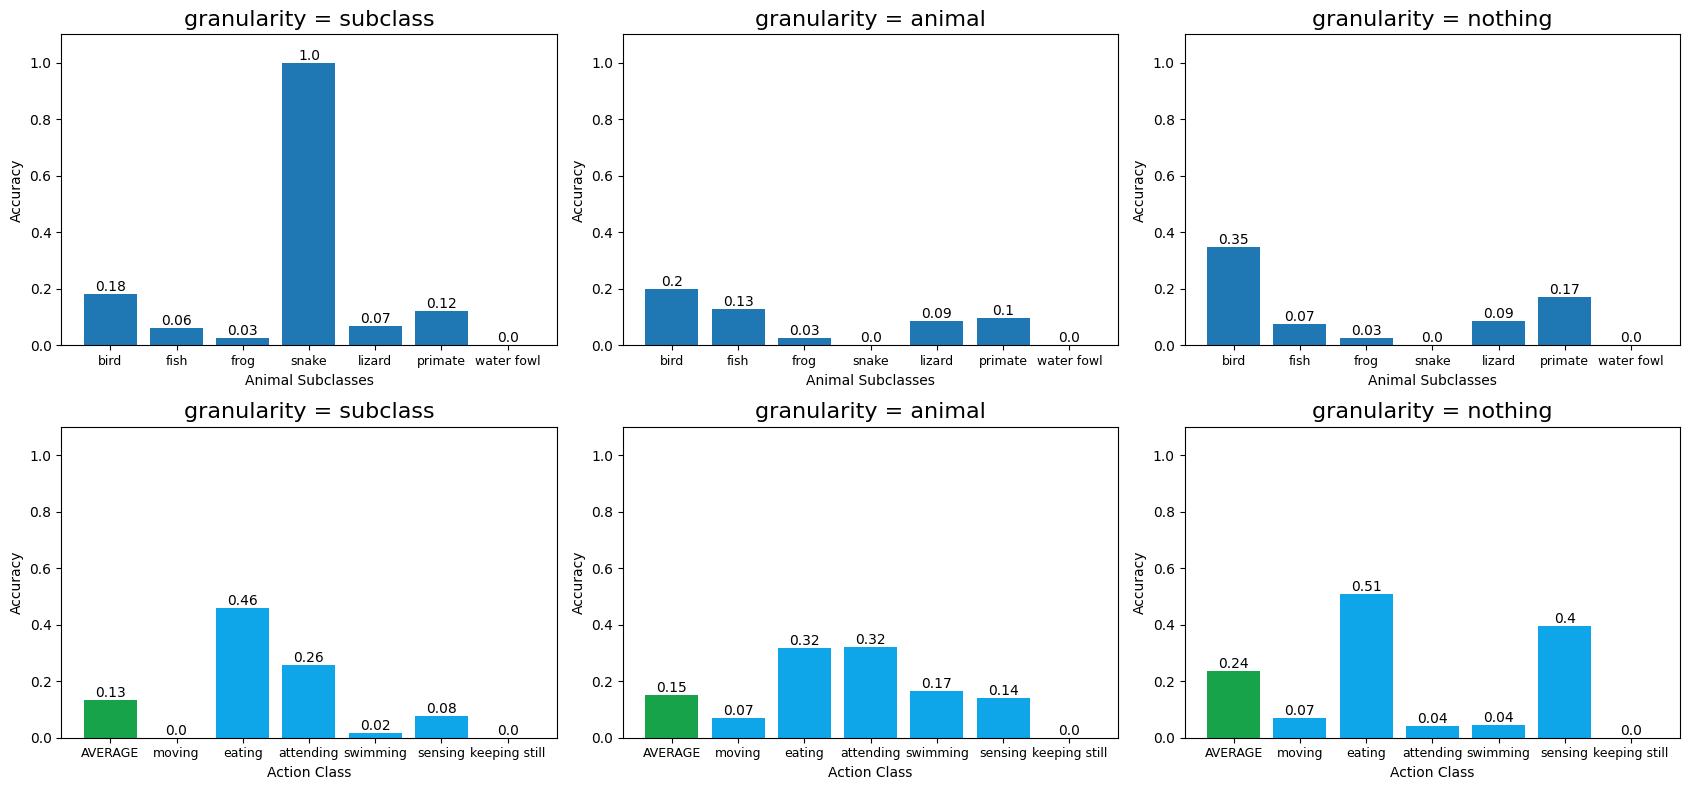

In [247]:
import matplotlib.pyplot as plt

# data processing for the first row (accuracy categorized by animal subclass)
categories1_subclass = list(database_train_subclass_copy.keys())
values1_subclass = list(database_train_subclass_copy.values())
categories1_subclass.insert(0, "AVERAGE")
values1_subclass.insert(0, database_train_subclass_avg.count(1) / len(database_train_subclass_avg))

categories2_subclass = list(database_val_subclass_copy.keys())
values2_subclass = list(database_val_subclass_copy.values())
categories2_subclass.insert(0, "AVERAGE")
values2_subclass.insert(0, database_val_subclass_avg.count(1) / len(database_val_subclass_avg))

categories1_animal = list(database_train_animal_copy.keys())
values1_animal = list(database_train_animal_copy.values())
categories1_animal.insert(0, "AVERAGE")
values1_animal.insert(0, database_train_animal_avg.count(1) / len(database_train_animal_avg))

categories2_animal = list(database_val_animal_copy.keys())
values2_animal = list(database_val_animal_copy.values())
categories2_animal.insert(0, "AVERAGE")
values2_animal.insert(0, database_val_animal_avg.count(1) / len(database_val_animal_avg))

categories1_nothing = list(database_train_nothing_copy.keys())
values1_nothing = list(database_train_nothing_copy.values())
categories1_nothing.insert(0, "AVERAGE")
values1_nothing.insert(0, database_train_nothing_avg.count(1) / len(database_train_nothing_avg))

categories2_nothing = list(database_val_nothing_copy.keys())
values2_nothing = list(database_val_nothing_copy.values())
categories2_nothing.insert(0, "AVERAGE")
values2_nothing.insert(0, database_val_nothing_avg.count(1) / len(database_val_nothing_avg))

# data processing for the second row (accuracy categorized by action)

categories3_subclass = list(database_actions_subclass_copy.keys())
values3_subclass = list(database_actions_subclass_copy.values())
categories3_subclass.insert(0, "AVERAGE")
values3_subclass.insert(0, database_actions_subclass_avg.count(1) / len(database_actions_subclass_avg))

categories3_animal = list(database_actions_animal_copy.keys())
values3_animal = list(database_actions_animal_copy.values())
categories3_animal.insert(0, "AVERAGE")
values3_animal.insert(0, database_actions_animal_avg.count(1) / len(database_actions_animal_avg))

categories3_nothing = list(database_actions_nothing_copy.keys())
values3_nothing = list(database_actions_nothing_copy.values())
categories3_nothing.insert(0, "AVERAGE")
values3_nothing.insert(0, database_actions_nothing_avg.count(1) / len(database_actions_nothing_avg))

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(17, 8))

ax1.bar(categories1_subclass[1:] + categories2_subclass[1:], values1_subclass[1:] + values2_subclass[1:])
ax1.set_xlabel('Animal Subclasses')
ax1.set_ylabel('Accuracy')
ax1.set_title('granularity = subclass', fontsize=16)
ax1.tick_params(axis='x', labelsize=9)
for i, v in enumerate(values1_subclass[1:] + values2_subclass[1:]):
    ax1.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax2.bar(categories1_animal[1:] + categories2_animal[1:], values1_animal[1:] + values2_animal[1:])
ax2.set_xlabel('Animal Subclasses')
ax2.set_ylabel('Accuracy')
ax2.set_title('granularity = animal', fontsize=16)
ax2.tick_params(axis='x', labelsize=9)
for i, v in enumerate(values1_animal[1:] + values2_animal[1:]):
    ax2.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax3.bar(categories1_nothing[1:] + categories2_nothing[1:], values1_nothing[1:] + values2_nothing[1:])
ax3.set_xlabel('Animal Subclasses')
ax3.set_ylabel('Accuracy')
ax3.set_title('granularity = nothing', fontsize=16)
ax3.tick_params(axis='x', labelsize=9)
for i, v in enumerate(values1_nothing[1:] + values2_nothing[1:]):
    ax3.text(i, v, str(round(v, 2)), ha='center', va='bottom')


# plot the second row (accuracy categorized by action)

ax4.bar(categories3_subclass, values3_subclass, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax4.set_xlabel('Action Class')
ax4.set_ylabel('Accuracy')
ax4.set_title('granularity = subclass', fontsize=16)
ax4.tick_params(axis='x', labelsize=9)
for i, v in enumerate(values3_subclass):
    ax4.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax5.bar(categories3_animal, values3_animal, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax5.set_xlabel('Action Class')
ax5.set_ylabel('Accuracy')
ax5.set_title('granularity = animal', fontsize=16)
ax5.tick_params(axis='x', labelsize=9)
for i, v in enumerate(values3_animal):
    ax5.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax6.bar(categories3_nothing, values3_nothing, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax6.set_xlabel('Action Class')
ax6.set_ylabel('Accuracy')
ax6.set_title('granularity = nothing', fontsize=16)
ax6.tick_params(axis='x', labelsize=9)
for i, v in enumerate(values3_nothing):
    ax6.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
ax3.set_ylim(0, 1.1)
ax4.set_ylim(0, 1.1)
ax5.set_ylim(0, 1.1)
ax6.set_ylim(0, 1.1)

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [210]:
import av
import torch
import numpy as np

from transformers import AutoProcessor, AutoModel
from huggingface_hub import hf_hub_download

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
container = av.open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/video/AAACXZTV.mp4")

# sample 8 frames
indices = sample_frame_indices(clip_len=8, frame_sample_rate= container.streams.video[0].frames // 8 - 1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")

inputs = processor(
    text=["ostrich standing", "bug standing", "cow standing"],
    videos=list(video),
    return_tensors="pt",
    padding=True,
)

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits_per_video = outputs.logits_per_video  # this is the video-text similarity score
probs = logits_per_video.softmax(dim=1)  # we can take the softmax to get the label probabilities
print(probs)


No accelerated colorspace conversion found from yuv420p to rgb24.
No accelerated colorspace conversion found from yuv420p to rgb24.
 (repeated 7 more times)


tensor([[0.6951, 0.2023, 0.1026]])


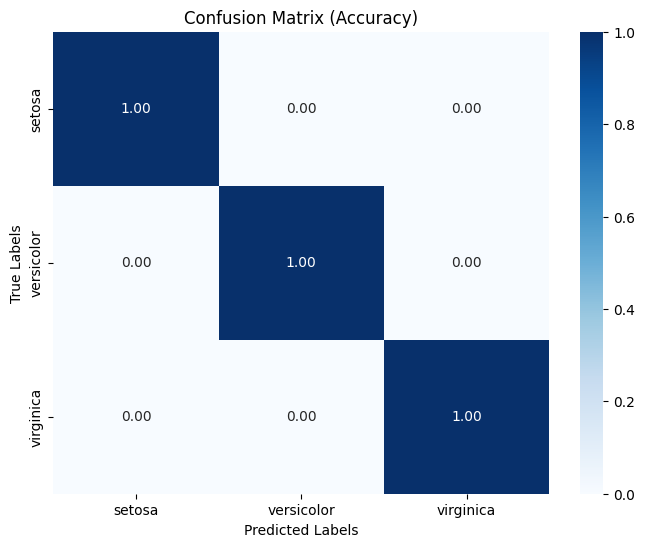

In [211]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Load example data (Iris dataset)
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (e.g., Support Vector Machine)
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy for each class and normalize the confusion matrix
class_accuracy = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap with accuracy percentages
plt.figure(figsize=(8, 6))
sns.heatmap(class_accuracy, annot=True, cmap='Blues', fmt='.2f', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Accuracy)')
plt.show()
